In [1]:
!pip install torch torchvision matplotlib opencv-python timm tqdm

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import timm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from transformers import ViTFeatureExtractor, ViTForImageClassification

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from google.colab import drive

drive.mount('/content/drive')

drive_dir = """/content/drive/MyDrive/KoreaUniv/2024/DEEP_LEARNING/Final_Project"""

Mounted at /content/drive


## pre-trained model

In [ ]:
model_name = "google/vit-base-patch16-224"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name)
model.eval()

## dataset

In [6]:
data_dir = drive_dir + "/datasets/Office-31/domain_adaptation_images"

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

In [8]:
amazon_dir = data_dir + '/amazon/images'
dslr_dir = data_dir + '/dslr/images'
webcam_dir = data_dir + '/webcam/images'

amazon_dataset = datasets.ImageFolder(root=amazon_dir, transform=transform)
dslr_dataset = datasets.ImageFolder(root=dslr_dir, transform=transform)
webcam_dataset = datasets.ImageFolder(root=webcam_dir, transform=transform)

In [9]:
classes = amazon_dataset.classes

In [56]:
office31_to_imagenet = {
    "back_pack": [414],           # backpack
    "bike": [671],                # mountain bike
    "bike_helmet": [518],         # crash halmet
    "bookcase": [453],            # bookcase
    "bottle": [440, 720, 737],    # beer bottle, pill bottle, pop bottle
    "calculator": [590],          # hand-held computer
    "desk_chair": [423, 559],     # barbar chair, folding chair
    "desk_lamp": [846],           # table lamp
    "desktop_computer": [527],    # desktop computer
    "file_cabinet": [553],        # file
    "headphones": [650],          # microphone
    "keyboard": [508],            # computer keyboard
    "laptop_computer": [620],     # laptop
    "letter_tray": [868, 446],  # tray, binder
    "mobile_phone": [487],        # cellular telephone
    "monitor": [664],             # monitor
    "mouse": [673],               # mouse
    "mug": [504],                 # coffee mug
    "paper_notebook": [893, 917, 921],  # pocketbook, comic book, book jacket
    "pen": [418, 563, 749],       # ball pen, fountain pen, quill pen
    "phone": [528, 707],          # dial phone, pay-phone
    "printer": [742],             # printer
    "projector": [745],           # projector
    "punchers": [-1],             # none
    "ring_binder": [446],         # ring binder
    "ruler": [769],                 # ruler
    "scissors": [473, 623],       # tin opener, paper knife
    "speaker": [632],             # loudspeaker
    "stapler": [-1],              # none
    "tape_dispenser": [-1],       # none
    "trash_can": [412]            # trash can
}

In [11]:
batch_size=32

In [12]:
amazon_loader = DataLoader(amazon_dataset, batch_size=batch_size, shuffle=True)
dslr_loader = DataLoader(dslr_dataset, batch_size=batch_size, shuffle=True)
webcam_loader = DataLoader(webcam_dataset, batch_size=batch_size, shuffle=True)

In [13]:
target_indices = [classes.index(label) for label in classes]

## Experiment

### test

Saving 스크린샷 2024-12-10 194723.png to 스크린샷 2024-12-10 194723.png
User uploaded file "스크린샷 2024-12-10 194723.png" with length 100929 bytes


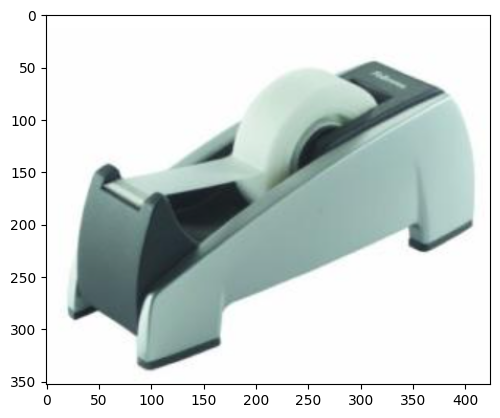

In [51]:
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

img = Image.open(fn).convert("RGB")
plt.imshow(img)
plt.show()

In [53]:
inputs = feature_extractor(images=img, return_tensors="pt")

model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()

labels = model.config.id2label
print(f"Predicted class: {labels[predicted_class_idx]}")

Predicted class: pencil sharpener


### eval function

In [58]:
def evaluate_model(model, dataloader, domain_name):
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            predictions = torch.argmax(outputs.logits, dim=-1)

            for i, pred in enumerate(predictions):
                office_class_name = classes[labels[i]]
                if pred.item() in office31_to_imagenet[office_class_name]:
                    correct += 1

                total += 1

    accuracy = correct / total
    print(f"Zero-shot Accuracy on {domain_name} Domain: {accuracy:.2%}")

### Amazon

In [59]:
evaluate_model(model, amazon_loader, "Amazon")

Zero-shot Accuracy on Amazon Domain: 55.02%


### DSLR

In [60]:
evaluate_model(model, dslr_loader, "DSLR")

Zero-shot Accuracy on DSLR Domain: 55.62%


### Webcam

In [61]:
evaluate_model(model, webcam_loader, "Webcam")

Zero-shot Accuracy on Webcam Domain: 55.85%
